## Exercises

Try out the following exercises to apply the concepts and techniques you have learned so far:

* Coding exercises on end-to-end model training: https://jovian.ai/aakashns/03-cifar10-feedforward
* Starter notebook for deep learning models:  https://jovian.ai/aakashns/fashion-feedforward-minimal

Training great machine learning models reliably takes practice and experience. Try experimenting with different datasets, models and hyperparameters, it's the best way to acquire this skill.

#### Flowchart of this project:
**1. Download the dataset**
2. Prepare the dataset for training and build dataset/dataloader
3. Write functions to connect with GPU
4. Construct Model class
5. Write fit function and run 20 epochs
6. Make predictions


In [1]:
import argparse
import os
import numpy as np
import math
from torchsummary import summary
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.optim as optim 
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


In [2]:
torch.manual_seed(111)

In [3]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())
len(mnist_trainset)
len(mnist_testset)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



10000

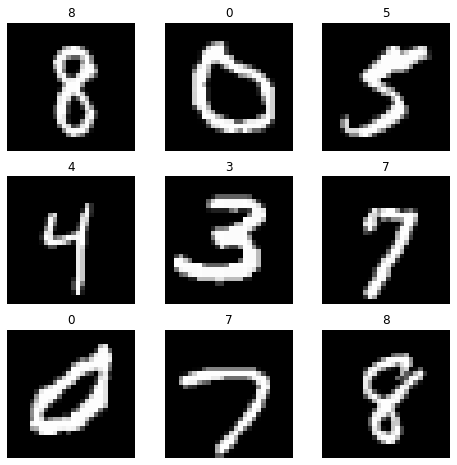

In [4]:
labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_trainset), size=(1,)).item()
    img, label = mnist_trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super (Generator,self).__init__()
        self.fc1 = nn.Linear(128, 256)
        self.relu1 = nn.LeakyReLU(0.25)
        self.fc2 = nn.Linear(256, 512)
        self.relu2 = nn.LeakyReLU(0.25)
        self.fc3 = nn.Linear(512,784)
        self.activation=nn.Tanh()
    
    def forward(self,x):
        x=self.relu1(self.fc1(x))
        x=self.relu2(self.fc2(x))
        x=self.fc3(x)
        return self.activation(x)



class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self). __init__()
        self.fc1 = nn.Linear(784, 512)
        self.relu1 = nn.LeakyReLU(0.25)
        self.fc2 = nn.Linear(512, 512)
        self.relu2 = nn.LeakyReLU(0.25)
        self.fc3 = nn.Linear(512,256)
        self.relu3 = nn.LeakyReLU(0.25)
        self.fc4 = nn.Linear(256,1)
        self.final= nn.Sigmoid()
    def forward(self,x):
        x=self.relu1(self.fc1(x))
        x=self.relu2(self.fc2(x))
        x=self.relu3(self.fc3(x))    
        x=self.fc4(x)
        return self.final(x)


model= Generator()
#summary(model,(1,128))


model2= Discriminator()
#summary(model2,(1,784))


In [6]:
adversarial_loss = torch.nn.BCELoss()
generator = Generator()
discriminator=Discriminator()
batch_size = 32
iterations = 50
number_of_epochs = 10
learning_rate = 0.01
pretrained = True
optimzergen= torch.optim.SGD(generator.parameters(),lr=learning_rate)
optimzerdis= torch.optim.SGD(generator.parameters(),lr=learning_rate)
Tensor =torch.FloatTensor
dataloader=DataLoader(mnist_trainset,batch_size=32,shuffle=True)


In [7]:
Generator_loss = []
Generator_counter = []
Discriminator_loss = []
test_counter = [i*len(dataloader) for i in range(number_of_epochs + 1)]


In [11]:
for i in tqdm(range(number_of_epochs)):
  running_loss=0.0
  running_loss2=0.0
  for n,batch in tqdm(enumerate(dataloader)):
      img,label = batch
      valid =torch.ones((img.size(0),1), requires_grad=False)
      fake = torch.zeros((img.size(0),1), requires_grad=False)
      #print(img.size(0))
      #Generator
      optimzergen.zero_grad()
      z = torch.tensor(np.random.normal(0, 1, (img.shape[0],128)),dtype=torch.float)
      gen_imgs = generator(z)
      g_loss = adversarial_loss(discriminator(gen_imgs), valid)
      g_loss.backward()
      optimzergen.step()
      Generator_loss.append(g_loss.item())
      running_loss += g_loss.item()* img.size(0)
      Generator_loss.append(running_loss/len(mnist_trainset))


      #Discriminitaor
      #rint(valid.size())
      #print(gen_imgs.size())
      #print(img.size())
      optimzerdis.zero_grad()
      
      #torch.flatten(img, start_dim=1)

      img.flatten(start_dim=1)
      #print(img.flatten(start_dim=1).size())
      #print(discriminator(img.flatten(start_dim=1)))
      real_loss = adversarial_loss(discriminator(img.flatten(start_dim=1)), valid)
      fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
      d_loss = (real_loss + fake_loss) / 2
      d_loss.backward()
      optimzerdis.step()

      running_loss2+= d_loss.item()* img.size(0)
      Discriminator_loss.append(running_loss2/len(mnist_trainset))

      batches_done = number_of_epochs * len(dataloader) + n
      #if batches_done %400 == 0:
       #     save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)




  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
4it [00:00, 37.42it/s]
8it [00:00, 35.64it/s]
12it [00:00, 34.22it/s]
16it [00:00, 35.31it/s]
20it [00:00, 35.46it/s]
24it [00:00, 33.47it/s]
28it [00:00, 32.11it/s]
32it [00:00, 30.92it/s]
36it [00:01, 30.69it/s]
40it [00:01, 30.17it/s]
44it [00:01, 29.04it/s]
47it [00:01, 29.14it/s]
50it [00:01, 28.41it/s]
54it [00:01, 30.48it/s]
58it [00:01, 31.82it/s]
62it [00:01, 32.86it/s]
66it [00:02, 32.58it/s]
70it [00:02, 33.73it/s]
74it [00:02, 34.57it/s]
78it [00:02, 34.87it/s]
82it [00:02, 35.71it/s]
86it [00:02, 35.79it/s]
90it [00:02, 34.63it/s]
94it [00:02, 33.95it/s]
98it [00:03, 32.77it/s]
102it [00:03, 32.23it/s]
106it [00:03, 31.25it/s]
110it [00:03, 31.96it/s]
  0%|          | 0/10 [00:03<?, ?it/s]


KeyboardInterrupt: ignored

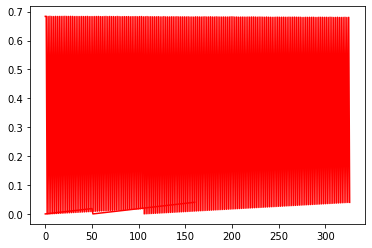

In [12]:
plt.plot(np.array(Generator_loss), 'r')
plt.plot(np.array(Discriminator_loss), 'r')
